In [44]:
from pathlib import Path
import sys

BASE_PATH = Path('../')
PATH_TO_DATA = BASE_PATH/'data'
PATH_TO_MODELS = BASE_PATH/'checkpoints'
PATH_TO_CACHE = BASE_PATH/'cache'
PATH_TO_LOGS = BASE_PATH/'logs'

PATH_TO_CACHE.mkdir(exist_ok=True, parents=True)
PATH_TO_DATA.mkdir(exist_ok=True, parents=True)
PATH_TO_MODELS.mkdir(exist_ok=True, parents=True)
PATH_TO_LOGS.mkdir(exist_ok=True, parents=True)


sys.path.append(str(BASE_PATH/'..'))

#### <b>Load Libraries</b>

In [45]:
import pprint
from copy import deepcopy
from tqdm import tqdm
import time
import random
from pathlib import Path
import pickle

from PIL import Image

import numpy as np
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torchvision import models
from torchvision import transforms
from torchvision.datasets import CIFAR10

from torch.utils.data import Dataset, DataLoader, Subset

from utils import progress_bar, load_model

#### <b>Notebook Constants</b>

In [46]:
RANDOM_STATE = 42
BATCH_SIZE = 256
NUM_WORKERS = 4
DEVICE = 'cuda'
NUM_CLASSES = 10

In [47]:
def set_random_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

#### <b>Define Custom Dataset</b>

In [48]:
train_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

cifar10_aug = CIFAR10(root=PATH_TO_DATA, train=True, transform=train_transforms)
cifar10 = CIFAR10(root=PATH_TO_DATA, train=True, transform=test_transforms)

test_dataset = CIFAR10(root=PATH_TO_DATA, train=False, transform=test_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [49]:
train_inds = np.load(PATH_TO_DATA/'train_inds.npy')
unseen_inds = np.load(PATH_TO_DATA/'unseen_inds.npy')
retain_inds = np.load(PATH_TO_DATA/'retain_inds.npy')
forget_inds = np.load(PATH_TO_DATA/'forget_inds.npy')
shadow_inds = np.load(PATH_TO_DATA/'shadow_inds.npy')


with open(PATH_TO_DATA/'data_split.pickle', 'rb') as file:
    data_split = pickle.load(file)

#### <b>Evalution utils</b>

In [50]:
def downstream_task_performance(model, dataloader):
    model.eval()
    top2_correct = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            outputs = model(inputs)

            _, preds = outputs.max(1)
            total += targets.size(0)
            correct += preds.eq(targets).sum().item()

            # Top-2 accuracy.
            _, top2_preds = outputs.topk(2, dim=1)
            top2_correct += top2_preds.eq(targets.view(-1, 1).expand_as(top2_preds)).any(dim=1).sum().item()

            progress_bar(batch_idx, len(dataloader), f'Acc: {100*correct/total:.2f}%%% Top2 Acc: {100*top2_correct/total:.2f}%%%')
    
    return 100*correct/total, 100*top2_correct/total

In [51]:
from MIA.score import get_logits, lira_offline, lira_online

def lira(target_net, train_inds, forget_inds, data_split, cached=True):

    num_aug = 1
    fix_variance = False

    if num_aug > 1:
        dataset = Subset(cifar10_aug, train_inds)
    else:
        dataset = Subset(cifar10, train_inds)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    labels = np.int64(~np.isin(train_inds, forget_inds))
    masks_in = [np.array(data_split[x]) for x in train_inds]
    
    if cached and (PATH_TO_CACHE/'shadow_logits.npy').is_file():
        shadow_logits = np.load(PATH_TO_CACHE/'shadow_logits.npy')
        print('Shadow logits were brought from cache')
    else:
        shadow_nets = [load_model(state_dict, NUM_CLASSES).to(DEVICE) for state_dict in (PATH_TO_MODELS/'shadow').glob('*/*')]
        shadow_logits = []
        for _ in range(num_aug):
            dataset_labels = []
            shadow_aug_logits = [[] for _ in range(len(shadow_nets))]
            with torch.no_grad():
                for batch_idx, (inputs, targets) in tqdm(enumerate(dataloader), total=len(dataloader)):
                    inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

                    for i, net in enumerate(shadow_nets):
                        logits = net(inputs).cpu().tolist()
                        shadow_aug_logits[i].append(logits)
                
                    dataset_labels.append(targets.cpu().tolist())

            shadow_aug_logits = np.stack([np.concatenate(logits) for logits in shadow_aug_logits])  # [n_shadow, n_examples, n_classes]
            dataset_labels = np.concatenate(dataset_labels)[:, None]  # [n_examples, 1]

            # Extract numerically stable logits
            shadow_aug_logits = get_logits(shadow_aug_logits, np.repeat(dataset_labels[None], len(shadow_nets), 0))
            shadow_logits.append(shadow_aug_logits)
        
        shadow_logits = np.stack(shadow_logits, axis=-1)
        shadow_logits = np.swapaxes(shadow_logits, 0, 1)  # [n_examples, n_shadow, n_aug]
        np.save(PATH_TO_CACHE/'shadow_logits.npy', shadow_logits)
    
    target_logits = []
    for _ in range(num_aug):
        dataset_labels = []
        target_aug_logits = []
        with torch.no_grad():
            for batch_idx, (inputs, targets) in tqdm(enumerate(dataloader), total=len(dataloader)):
                inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

                logits = target_net(inputs).cpu().tolist()
                target_aug_logits.append(logits)
        
                dataset_labels.append(targets.cpu().tolist())
            
        
        target_aug_logits = np.concatenate(target_aug_logits)  # [n_examples, n_classes]
        dataset_labels = np.concatenate(dataset_labels)[:, None]  # [n_examples, 1]

        # Extract numerically stable logits
        target_aug_logits = get_logits(target_aug_logits, dataset_labels)

        target_logits.append(target_aug_logits)

    target_logits = np.stack(target_logits, axis=-1)  # [n_examples, n_aug]

    fnr, tnr, auc, low = lira_online(target_logits, shadow_logits, labels, masks_in, fix_variance=fix_variance)

    return fnr, tnr, auc, low

In [52]:
def shockri(model, train_inds, forget_inds):

    with open(PATH_TO_MODELS/'atacker.pickle', 'rb') as file:
        atacker = pickle.load(file)


    dataset = Subset(cifar10, train_inds)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

    target_logits = []
    dataset_labels = []

    with torch.no_grad():
        for batch_idx, (inputs, targets) in tqdm(enumerate(dataloader), total=len(dataloader)):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            logits = model(inputs).log_softmax(1).cpu().tolist()
            target_logits.append(logits)
    
            dataset_labels.append(targets.cpu().tolist())
        
    
    target_logits = np.concatenate(target_logits)
    dataset_labels = np.concatenate(dataset_labels)

    df = pd.DataFrame(target_logits, columns = [f'feature_{i}' for i in  range(NUM_CLASSES)])
    df['ce_loss'] = -target_logits[range(target_logits.shape[0]), dataset_labels.reshape(-1)]
    df['target'] = np.int64(~np.isin(train_inds, forget_inds))

    df['pred'] = atacker.predict_proba(df[atacker.feature_names_in_])[:, 1]

    fpr, tpr, thresholds = metrics.roc_curve(df['target'], df['pred'])

    fnr = 1 - tpr
    tnr = 1 - fpr

    low = metrics.confusion_matrix(df['target'], (df['pred'] > 0.400).astype(int),normalize='true').ravel()[0]
    auc = metrics.auc(fnr, tnr)
    
    return fnr, tnr, auc, low




In [53]:
def evaluate_unlearning(model, forget_inds, retain_inds):

    global cifar10, train_inds, data_split, unseen_inds, test_dataloader

    unseen_dataset = Subset(cifar10, unseen_inds)
    unseen_dataloader = DataLoader(unseen_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

    forget_dataset = Subset(cifar10, forget_inds)
    forget_dataloader = DataLoader(forget_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

    retain_dataset = Subset(cifar10, retain_inds)
    retain_dataloader = DataLoader(retain_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

    model.eval()
    
    retain_acc = downstream_task_performance(model, retain_dataloader)
    forget_acc = downstream_task_performance(model, forget_dataloader)
    test_acc = downstream_task_performance(model, test_dataloader)
    unseen_acc = downstream_task_performance(model, unseen_dataloader)
    fnr, tnr, auc, low = shockri(model, train_inds, forget_inds)

    result_df = pd.DataFrame(
            index=[
                'retain_acc',
                'forget_acc',
                'test_acc',
                'unseen_acc',
                'MIA_AUC','MIA_TNR@5%FNR'
            ],
            data=[
                np.round(retain_acc[0], 2),
                np.round(forget_acc[0], 2),
                np.round(test_acc[0], 2),
                np.round(unseen_acc[0], 2),
                np.round(100*auc, 2),
                np.round(100*low, 2)
            ]
            ).T

    return result_df, fnr, tnr


#### <b>Evaluate origin model</b>

 [=======================================>]  Step: 4ms | Tot: 620ms | Acc: 89.05%%% Top2 Acc: 96.75% 84/84   
 [================================>.......]  Step: 4ms | Tot: 16ms | Acc: 89.16%%% Top2 Acc: 96.80% 5/5  
 [=======================================>]  Step: 3ms | Tot: 286ms | Acc: 75.21%%% Top2 Acc: 88.86% 40/40  ============================>...........]  Step: 10ms | Tot: 209ms | Acc: 75.39%%% Top2 Acc: 88.97% 29/40 
 [======================================>.]  Step: 4ms | Tot: 133ms | Acc: 75.70%%% Top2 Acc: 90.22% 20/20  


100%|██████████| 88/88 [00:00<00:00, 113.01it/s]


,retain_acc,forget_acc,test_acc,unseen_acc,MIA_AUC,MIA_TNR@5%FNR
0,89.05,89.16,75.21,75.7,49.51,3.02


|    |   retain_acc |   forget_acc |   test_acc |   unseen_acc |   MIA_AUC |   MIA_TNR@5%FNR |
|---:|-------------:|-------------:|-----------:|-------------:|----------:|----------------:|
|  0 |        89.05 |        89.16 |      75.21 |         75.7 |     49.51 |            3.02 |


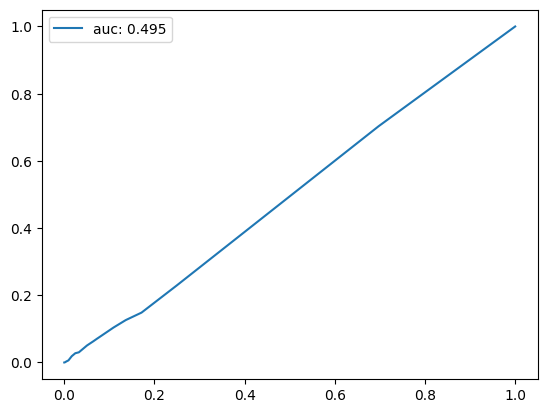

In [54]:
model = load_model(PATH_TO_MODELS/'origin'/'state_dict.pth', NUM_CLASSES)
model.to(DEVICE)

df_metrics, fnr, tnr = evaluate_unlearning(model, forget_inds, retain_inds)
 
display(df_metrics)

plt.plot(fnr, tnr, label=f'auc: {metrics.auc(fnr, tnr):.3f}')
plt.legend()

print(df_metrics.to_markdown())

#### <b>Evaluate retrained model</b>

 [=======================================>]  Step: 3ms | Tot: 602ms | Acc: 90.18%%% Top2 Acc: 97.01% 84/84  
 [================================>.......]  Step: 3ms | Tot: 16ms | Acc: 74.93%%% Top2 Acc: 89.69% 5/5  
 [=======================================>]  Step: 3ms | Tot: 276ms | Acc: 75.93%%% Top2 Acc: 89.24% 40/40  
 [======================================>.]  Step: 3ms | Tot: 166ms | Acc: 76.06%%% Top2 Acc: 89.86% 20/20  


100%|██████████| 88/88 [00:00<00:00, 122.59it/s]


,retain_acc,forget_acc,test_acc,unseen_acc,MIA_AUC,MIA_TNR@5%FNR
0,90.18,74.93,75.93,76.06,59.39,14.4


|    |   retain_acc |   forget_acc |   test_acc |   unseen_acc |   MIA_AUC |   MIA_TNR@5%FNR |
|---:|-------------:|-------------:|-----------:|-------------:|----------:|----------------:|
|  0 |        90.18 |        74.93 |      75.93 |        76.06 |     59.39 |            14.4 |


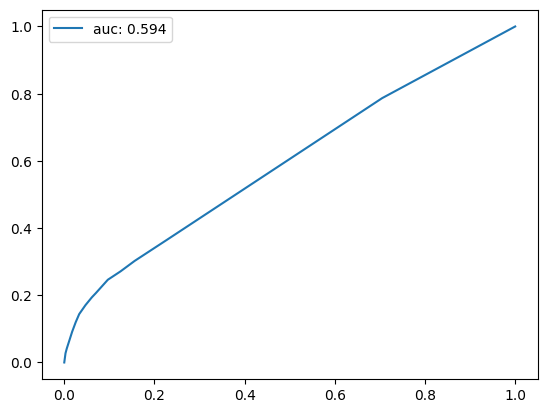

In [55]:
model = load_model(PATH_TO_MODELS/'retrained'/'state_dict.pth', NUM_CLASSES)
model.to(DEVICE)

df_metrics, fnr, tnr = evaluate_unlearning(model, forget_inds, retain_inds)
 
display(df_metrics)

plt.plot(fnr, tnr, label=f'auc: {metrics.auc(fnr, tnr):.3f}')
plt.legend()

print(df_metrics.to_markdown())

#### <b>Unlearning</b>

##### <b>Fine Tuning</b>

In [56]:
def fine_tune_unlearning(model, forget_inds, retain_inds, unseen_inds):

    set_random_seed(RANDOM_STATE)
    
    model.train()
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    dataset = Subset(cifar10_aug, retain_inds)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

    num_epochs = 10
    for epoch in range(num_epochs):
        for inputs, targets in tqdm(dataloader, desc=f'epoch {epoch}/{num_epochs}', leave=False):
            
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    model.eval()

 [=======================================>]  Step: 3ms | Tot: 598ms | Acc: 89.41%%% Top2 Acc: 96.93% 84/84   
 [================================>.......]  Step: 4ms | Tot: 16ms | Acc: 88.80%%% Top2 Acc: 96.53% 5/5  
 [=======================================>]  Step: 3ms | Tot: 277ms | Acc: 75.19%%% Top2 Acc: 88.81% 40/40  
 [======================================>.]  Step: 3ms | Tot: 126ms | Acc: 75.82%%% Top2 Acc: 89.90% 20/20  


100%|██████████| 88/88 [00:00<00:00, 96.02it/s] 


,retain_acc,forget_acc,test_acc,unseen_acc,MIA_AUC,MIA_TNR@5%FNR,unlearning_time
0,89.41,88.8,75.19,75.82,50.17,3.64,12


|    |   retain_acc |   forget_acc |   test_acc |   unseen_acc |   MIA_AUC |   MIA_TNR@5%FNR |   unlearning_time |
|---:|-------------:|-------------:|-----------:|-------------:|----------:|----------------:|------------------:|
|  0 |        89.41 |         88.8 |      75.19 |        75.82 |     50.17 |            3.64 |                12 |


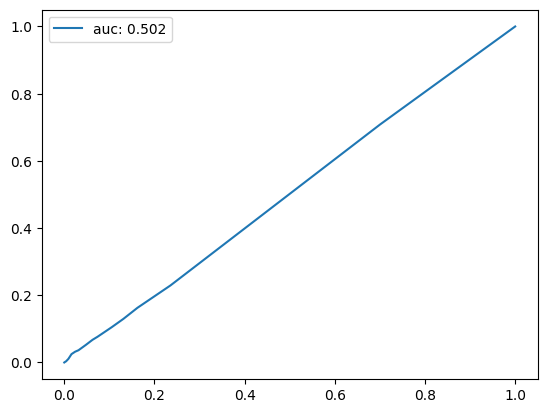

In [57]:
model = load_model(PATH_TO_MODELS/'origin'/'state_dict.pth', NUM_CLASSES)
model.to(DEVICE)

start = time.time()
fine_tune_unlearning(model, forget_inds, retain_inds, unseen_inds)
unlearning_time = time.time() - start

df_metrics, fnr, tnr = evaluate_unlearning(model, forget_inds, retain_inds)
df_metrics['unlearning_time'] = round(unlearning_time)
display(df_metrics)

plt.plot(fnr, tnr, label=f'auc: {metrics.auc(fnr, tnr):.3f}')
plt.legend()

print(df_metrics.to_markdown())

##### <b>Fine Tuning with random labels</b>

In [58]:
def random_labels_unlearning(model, forget_inds, retain_inds, unseen_inds):

    set_random_seed(RANDOM_STATE)

    class CustomDataset(Dataset):
        def __init__(self, inds, targets):
            self.dataset = Subset(cifar10_aug, inds)
            self.targets = targets

        def __len__(self):
            return len(self.dataset)

        def __getitem__(self, index):
            return self.dataset[index][0], self.targets[index]

    inds = np.concatenate([retain_inds, forget_inds])
    targets = np.concatenate([np.array(cifar10_aug.targets)[retain_inds], np.random.randint(0, NUM_CLASSES, size=len(forget_inds))])

    dataset = CustomDataset(inds, targets)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

    model.train()
    model.to(DEVICE)
    
    CE = torch.nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=5e-4)

    num_epochs = 10
    for epoch in range(num_epochs):
        for inputs, labels in tqdm(dataloader, desc=f'epoch {epoch}/{num_epochs}', leave=False):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            outputs = model(inputs)
            loss = CE(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    model.eval()

 [=======================================>]  Step: 4ms | Tot: 605ms | Acc: 87.80%%% Top2 Acc: 96.50% 84/84   
 [================================>.......]  Step: 3ms | Tot: 18ms | Acc: 76.44%%% Top2 Acc: 89.96% 5/5  
 [=======================================>]  Step: 3ms | Tot: 292ms | Acc: 74.06%%% Top2 Acc: 88.12% 40/40  
 [======================================>.]  Step: 3ms | Tot: 127ms | Acc: 74.82%%% Top2 Acc: 89.06% 20/20  


100%|██████████| 88/88 [00:00<00:00, 122.81it/s]


,retain_acc,forget_acc,test_acc,unseen_acc,MIA_AUC,MIA_TNR@5%FNR,unlearning_time
0,87.8,76.44,74.06,74.82,58.97,7.73,13


|    |   retain_acc |   forget_acc |   test_acc |   unseen_acc |   MIA_AUC |   MIA_TNR@5%FNR |   unlearning_time |
|---:|-------------:|-------------:|-----------:|-------------:|----------:|----------------:|------------------:|
|  0 |         87.8 |        76.44 |      74.06 |        74.82 |     58.97 |            7.73 |                13 |


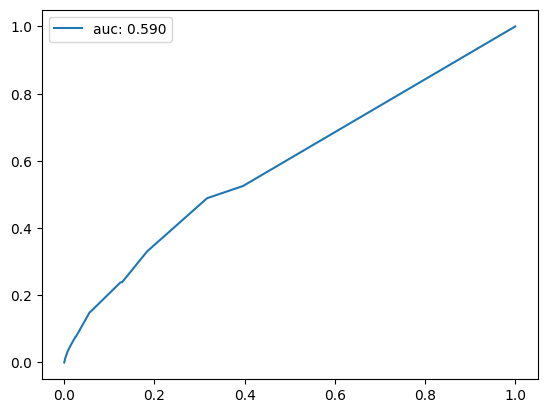

In [59]:
model = load_model(PATH_TO_MODELS/'origin'/'state_dict.pth', NUM_CLASSES)
model.to(DEVICE)

start = time.time()
random_labels_unlearning(model, forget_inds, retain_inds, unseen_inds)
unlearning_time = time.time() - start

df_metrics, fnr, tnr = evaluate_unlearning(model, forget_inds, retain_inds)
df_metrics['unlearning_time'] = round(unlearning_time)
display(df_metrics)

plt.plot(fnr, tnr, label=f'auc: {metrics.auc(fnr, tnr):.3f}')
plt.legend()

print(df_metrics.to_markdown())

##### <b>Fine Tuning with NOT random labels</b>

In [60]:
def not_random_labels_unlearning(model, forget_inds, retain_inds, unseen_inds):

    set_random_seed(RANDOM_STATE)

    feature_extractor = models.convnext_tiny(weights='DEFAULT')
    def get_features(name):
        def hook(model, input, output):
            features[name] = output.detach()
        return hook
    feature_extractor.avgpool.register_forward_hook(get_features('feats'))
    feature_extractor.eval()
    feature_extractor.to(DEVICE)

    model.eval()
    model.to(DEVICE)

    unseen_dataset = Subset(cifar10, unseen_inds)
    unseen_dataloader = DataLoader(unseen_dataset, shuffle=False, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
    forget_dataset = Subset(cifar10, forget_inds)
    forget_dataloader = DataLoader(forget_dataset, shuffle=False, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

    forget_feats = []
    forget_preds = []
    forget_targets = []

    unseen_feats = []
    unseen_preds = []
    unseen_targets = []

    features = {}

    for inputs, targets in tqdm(unseen_dataloader):
        inputs = inputs.to(DEVICE)
        unseen_preds.append(model(inputs).log_softmax(1).detach().cpu())
        feature_extractor(inputs)
        unseen_feats.append(features['feats'].squeeze().cpu())
        unseen_targets.append(targets.detach().cpu())

    unseen_preds = torch.cat(unseen_preds)
    unseen_feats = torch.cat(unseen_feats)
    unseen_targets = torch.cat(unseen_targets)

    for inputs, targets in tqdm(forget_dataloader):
        inputs = inputs.to(DEVICE)
        forget_preds.append(model(inputs).log_softmax(1).detach().cpu())
        feature_extractor(inputs)
        forget_feats.append(features['feats'].squeeze().cpu())
        forget_targets.append(targets.detach().cpu())

    forget_preds = torch.cat(forget_preds)
    forget_feats = torch.cat(forget_feats)
    forget_targets = torch.cat(forget_targets)

    # change targets with closest from unseen
    for i, x in enumerate(forget_feats):
        j = F.cosine_similarity(x, unseen_feats).argmax()
        forget_preds[i] = unseen_preds[j]
        forget_targets[i] = unseen_targets[j]

    inds = np.concatenate([retain_inds, forget_inds])
    targets = torch.cat([torch.tensor(cifar10_aug.targets)[retain_inds], forget_targets])

    class CustomDataset(Dataset):
        def __init__(self, inds, targets):
            self.dataset = Subset(cifar10_aug, inds)
            self.targets = targets

        def __len__(self):
            return len(self.dataset)

        def __getitem__(self, index):
            return self.dataset[index][0], self.targets[index]

    dataset = CustomDataset(inds, targets)
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

    model.train()
    model.to(DEVICE)
    
    CE = torch.nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=5e-4)

    num_epochs = 20
    for epoch in range(num_epochs):
        for inputs, labels in tqdm(dataloader, desc=f'epoch {epoch}/{num_epochs}', leave=False):
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            outputs = model(inputs)
            loss = CE(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    model.eval()

100%|██████████| 5/5 [00:00<00:00, 23.86it/s]


 [=======================================>]  Step: 4ms | Tot: 612ms | Acc: 91.27%%% Top2 Acc: 98.03% 84/84   
 [================================>.......]  Step: 4ms | Tot: 17ms | Acc: 73.33%%% Top2 Acc: 88.98% 5/5  
 [=======================================>]  Step: 3ms | Tot: 273ms | Acc: 74.08%%% Top2 Acc: 88.23% 40/40  
 [======================================>.]  Step: 3ms | Tot: 128ms | Acc: 74.54%%% Top2 Acc: 89.00% 20/20  


100%|██████████| 88/88 [00:00<00:00, 121.98it/s]


,retain_acc,forget_acc,test_acc,unseen_acc,MIA_AUC,MIA_TNR@5%FNR,unlearning_time
0,91.27,73.33,74.08,74.54,61.68,12.98,27


|    |   retain_acc |   forget_acc |   test_acc |   unseen_acc |   MIA_AUC |   MIA_TNR@5%FNR |   unlearning_time |
|---:|-------------:|-------------:|-----------:|-------------:|----------:|----------------:|------------------:|
|  0 |        91.27 |        73.33 |      74.08 |        74.54 |     61.68 |           12.98 |                27 |


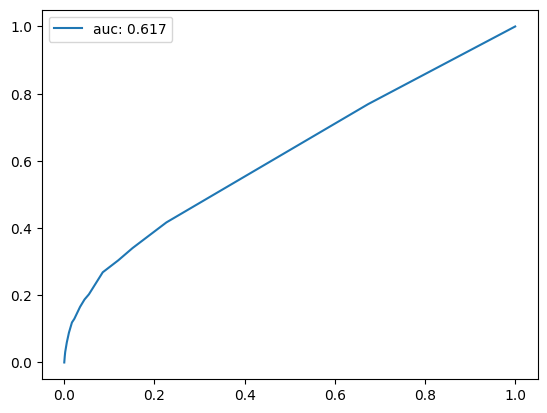

In [61]:
model = load_model(PATH_TO_MODELS/'origin'/'state_dict.pth', NUM_CLASSES)
model.to(DEVICE)

start = time.time()
not_random_labels_unlearning(model, forget_inds, retain_inds, unseen_inds)
unlearning_time = time.time() - start

df_metrics, fnr, tnr = evaluate_unlearning(model, forget_inds, retain_inds)
df_metrics['unlearning_time'] = round(unlearning_time)
display(df_metrics)

plt.plot(fnr, tnr, label=f'auc: {metrics.auc(fnr, tnr):.3f}')
plt.legend()

print(df_metrics.to_markdown())

##### <b>Negative gradient</b>

In [62]:
def neg_grad_unlearning(model, forget_inds, retain_inds, unseen_inds):

    set_random_seed(RANDOM_STATE)
    
    model.train()
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    dataset = Subset(cifar10_aug, forget_inds)
    forget_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

    dataset = Subset(cifar10_aug, retain_inds)
    retain_dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

    num_epochs = 10
    for epoch in range(num_epochs):
        for inputs, targets in tqdm(forget_dataloader, desc=f'epoch {epoch}/{num_epochs}', leave=False):
            
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            outputs = model(inputs)
            loss = -criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    for epoch in range(1):
        for inputs, targets in tqdm(retain_dataloader, leave=False):
            
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

            outputs = model(inputs)
            loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    model.eval()

 [=======================================>]  Step: 3ms | Tot: 602ms | Acc: 88.58%%% Top2 Acc: 96.66% 84/84  
 [================================>.......]  Step: 4ms | Tot: 21ms | Acc: 87.29%%% Top2 Acc: 95.64% 5/5  
 [=======================================>]  Step: 3ms | Tot: 276ms | Acc: 75.12%%% Top2 Acc: 88.88% 40/40  
 [======================================>.]  Step: 3ms | Tot: 128ms | Acc: 75.22%%% Top2 Acc: 89.60% 20/20  


100%|██████████| 88/88 [00:00<00:00, 103.51it/s]


,retain_acc,forget_acc,test_acc,unseen_acc,MIA_AUC,MIA_TNR@5%FNR,unlearning_time
0,88.58,87.29,75.12,75.22,51.38,5.51,4


|    |   retain_acc |   forget_acc |   test_acc |   unseen_acc |   MIA_AUC |   MIA_TNR@5%FNR |   unlearning_time |
|---:|-------------:|-------------:|-----------:|-------------:|----------:|----------------:|------------------:|
|  0 |        88.58 |        87.29 |      75.12 |        75.22 |     51.38 |            5.51 |                 4 |


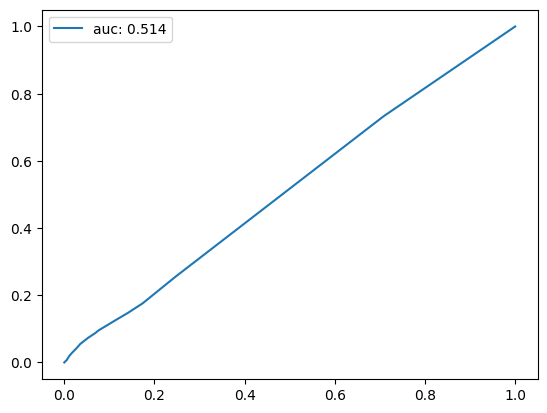

In [63]:
model = load_model(PATH_TO_MODELS/'origin'/'state_dict.pth', NUM_CLASSES)
model.to(DEVICE)

start = time.time()
neg_grad_unlearning(model, forget_inds, retain_inds, unseen_inds)
unlearning_time = time.time() - start

df_metrics, fnr, tnr = evaluate_unlearning(model, forget_inds, retain_inds)
df_metrics['unlearning_time'] = round(unlearning_time)
display(df_metrics)

plt.plot(fnr, tnr, label=f'auc: {metrics.auc(fnr, tnr):.3f}')
plt.legend()

print(df_metrics.to_markdown())

##### <b>UnGAN</b>

In [64]:
hidden_size=128

class Discriminator(nn.Module):
    def __init__(self, num_classes):
        super(Discriminator, self).__init__()
        self.class_embeddings = nn.Embedding(num_classes, num_classes)
        
        self.model = nn.Sequential(
            nn.Linear(2*num_classes, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 2*hidden_size),
            nn.ReLU(),
            nn.Linear(2*hidden_size, 2*hidden_size),
            nn.ReLU(),
            nn.Linear(2*hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
        )
        
    def forward(self, logits, label):
        label_emb = self.class_embeddings(label)
        z = torch.hstack([logits, label_emb])
        return self.model(z).flatten()


class Trainer:
    def __init__(self, model):
        
        self.discriminator = Discriminator(NUM_CLASSES)
        self.model = model
        self.alpha = 0.1

        self.model.cuda()
        self.discriminator.cuda()
        
        self.d_optimizer = torch.optim.Adam(self.discriminator.parameters(), lr=1.2e-3, weight_decay=1e-5)
        self.d_criterion = nn.BCEWithLogitsLoss()

        self.g_optimizer = torch.optim.Adam(self.model.parameters(), lr=2e-5, weight_decay=1e-5)
        self.g_criterion = nn.CrossEntropyLoss(reduction='mean')
        

    def generator_step(self, forget_logits, forget_labels, retain_logits, retain_labels):
        
        ones = torch.ones(forget_logits.size(0)).cuda()
        forget_preds = self.discriminator(forget_logits, forget_labels)
        d_loss = self.d_criterion(forget_preds, ones)
        
        g_loss = self.g_criterion(retain_logits, retain_labels)

        loss = d_loss + self.alpha * g_loss

        self.g_optimizer.zero_grad()
        loss.backward()
        self.g_optimizer.step()

        return loss.item()
        
    def discriminator_step(self, forget_logits, forget_labels, unseen_logits, unseen_labels):
        
        ones = torch.ones(unseen_logits.size(0)).cuda()
        zeros = torch.zeros(forget_logits.size(0)).cuda()
    
        forget_preds = self.discriminator(forget_logits, forget_labels)
        unseen_preds = self.discriminator(unseen_logits, unseen_labels)
    
        loss = self.d_criterion(forget_preds, zeros) + self.d_criterion(unseen_preds, ones)
        self.d_optimizer.zero_grad()
        loss.backward()
        self.d_optimizer.step()

        return loss.item()
        
        
def ungan_unlearning(model, forget_manifest, retain_manifest, unseen_manifest):

    set_random_seed(RANDOM_STATE)
    
    dataset = Subset(cifar10, forget_inds)
    forget = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

    dataset = Subset(cifar10_aug, retain_inds)
    retain = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

    dataset = Subset(cifar10, unseen_inds)
    unseen = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)

    trainer = Trainer(model)
    epochs = 20
    n_range = 10
    average_loss = None

    trainer.model.eval()
    unseen_logits_all, unseen_labels_all = [], []
    with torch.no_grad():
        for u in tqdm(unseen, desc='score unseen', leave=False):
            unseen_logits_all.append(trainer.model(u[0].to(DEVICE)))
            unseen_labels_all.append(u[1].to(DEVICE))
    unseen_logits_all = torch.cat(unseen_logits_all)
    unseen_labels_all = torch.cat(unseen_labels_all)

    trainer.model.train()
    for epoch in tqdm(range(epochs)):
        
        trainer.model.eval()
        for (forget_batch, retain_batch) in zip(forget, retain):
            n = 0
            while True:
                for forget_batch in forget:
                
                    with torch.no_grad():
                        forget_logits, forget_labels = trainer.model(forget_batch[0].to(DEVICE)), forget_batch[1].to(DEVICE)

                    inds = np.random.choice(len(unseen_logits_all), size=BATCH_SIZE, replace=False)
                    unseen_logits, unseen_labels = unseen_logits_all[inds], unseen_labels_all[inds]

                    d_loss = trainer.discriminator_step(forget_logits, forget_labels, unseen_logits, unseen_labels)
                    average_loss = d_loss if average_loss is None else 0.9 * average_loss + 0.1 * d_loss
                    n_range = min(n_range//2, 1) if average_loss < 1.0 else 10
                    n += 1
                    if n >= n_range: break
                if n >= n_range: break

            
            forget_features, forget_labels = forget_batch[0].cuda(), forget_batch[1].cuda()
            forget_logits = trainer.model(forget_features)

            trainer.model.train()
            retain_features, retain_labels = retain_batch[0].cuda(), retain_batch[1].cuda()
            retain_logits = trainer.model(retain_features)
        
            g_loss = trainer.generator_step(forget_logits, forget_labels, retain_logits, retain_labels)
                
    trainer.model.eval()

100%|██████████| 20/20 [00:36<00:00,  1.84s/it]              


 [=======================================>]  Step: 3ms | Tot: 601ms | Acc: 84.62%%% Top2 Acc: 94.86% 84/84   =============>..........................]  Step: 5ms | Tot: 211ms | Acc: 84.31%%% Top2 Acc: 95.00% 30/84 
 [================================>.......]  Step: 4ms | Tot: 18ms | Acc: 81.69%%% Top2 Acc: 93.78% 5/5  
 [=======================================>]  Step: 3ms | Tot: 277ms | Acc: 72.49%%% Top2 Acc: 87.39% 40/40  
 [======================================>.]  Step: 3ms | Tot: 135ms | Acc: 73.18%%% Top2 Acc: 88.08% 20/20  


100%|██████████| 88/88 [00:00<00:00, 115.04it/s]


,retain_acc,forget_acc,test_acc,unseen_acc,MIA_AUC,MIA_TNR@5%FNR,unlearning_time
0,84.62,81.69,72.49,73.18,53.34,7.91,37


|    |   retain_acc |   forget_acc |   test_acc |   unseen_acc |   MIA_AUC |   MIA_TNR@5%FNR |   unlearning_time |
|---:|-------------:|-------------:|-----------:|-------------:|----------:|----------------:|------------------:|
|  0 |        84.62 |        81.69 |      72.49 |        73.18 |     53.34 |            7.91 |                37 |


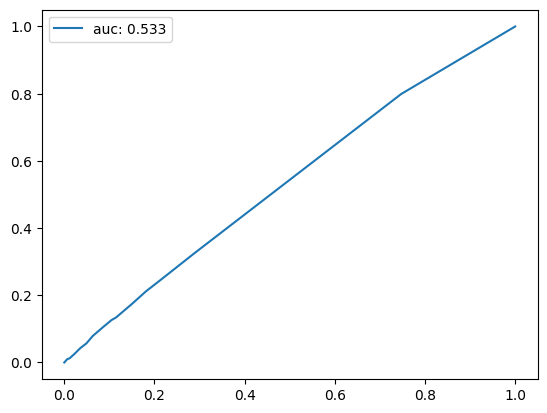

In [65]:
model = load_model(PATH_TO_MODELS/'origin'/'state_dict.pth', NUM_CLASSES)
model.to(DEVICE)

start = time.time()
ungan_unlearning(model, forget_inds, retain_inds, unseen_inds)
unlearning_time = time.time() - start

df_metrics, fnr, tnr = evaluate_unlearning(model, forget_inds, retain_inds)
df_metrics['unlearning_time'] = round(unlearning_time)
display(df_metrics)

plt.plot(fnr, tnr, label=f'auc: {metrics.auc(fnr, tnr):.3f}')
plt.legend()

print(df_metrics.to_markdown())